# Implementation of Federated Learning Method in Pytorch

In this scenario, there is a central server and 4 clients who are collaboratively training a machine learning model.
Initial model is a CNN model with at 4 convolutionalvlayers followed by 2 linear layers.
We divide the MNIST Digit training dataset evenly among the 4 clients and get a separate local training dataset for each client.
We use FedAvg algorithm for averaging the model updates coming from the clients.
Once the training is over, we plot the train and test set performance of the global model in a single graph.

In [ ]:
# Import Required Libraries
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [ ]:
# Define the CNN Model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 1 * 1, 256)  # Adjusted based on the actual output size
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 28x28 -> 14x14
        x = self.pool(F.relu(self.conv2(x)))  # 14x14 -> 7x7
        x = self.pool(F.relu(self.conv3(x)))  # 7x7 -> 3x3
        x = self.pool(F.relu(self.conv4(x)))  # 3x3 -> 1x1
        x = x.view(-1, 128 * 1 * 1)           # Adjusted view size
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
# Load and Split the MNIST Dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Split the training data into 4 equal parts
client_datasets = random_split(mnist_train, [15000, 15000, 15000, 15000])
test_loader = DataLoader(mnist_test, batch_size=1000, shuffle=False)

In [ ]:
# Define Training and Evaluation Functions
def train(model, data_loader, criterion, optimizer, epochs=1):
    model.train()
    for _ in range(epochs):
        for data, target in data_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

def evaluate(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in data_loader:
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    return 100 * correct / total

In [ ]:
# Federated Averaging Algorithm (FedAvg)
def fed_avg(global_model, client_models):
    global_dict = global_model.state_dict()
    for k in global_dict.keys():
        global_dict[k] = torch.stack([client_models[i].state_dict()[k].float() for i in range(len(client_models))], 0).mean(0)
    global_model.load_state_dict(global_dict)

Round 1
Train Accuracy: 11.24%, Test Accuracy: 11.35%
Round 2
Train Accuracy: 11.24%, Test Accuracy: 11.35%
Round 3
Train Accuracy: 11.24%, Test Accuracy: 11.35%
Round 4
Train Accuracy: 19.18%, Test Accuracy: 19.25%
Round 5
Train Accuracy: 19.78%, Test Accuracy: 19.97%
Round 6
Train Accuracy: 62.26%, Test Accuracy: 62.29%
Round 7
Train Accuracy: 80.31%, Test Accuracy: 80.16%
Round 8
Train Accuracy: 89.16%, Test Accuracy: 89.19%
Round 9
Train Accuracy: 92.14%, Test Accuracy: 92.18%


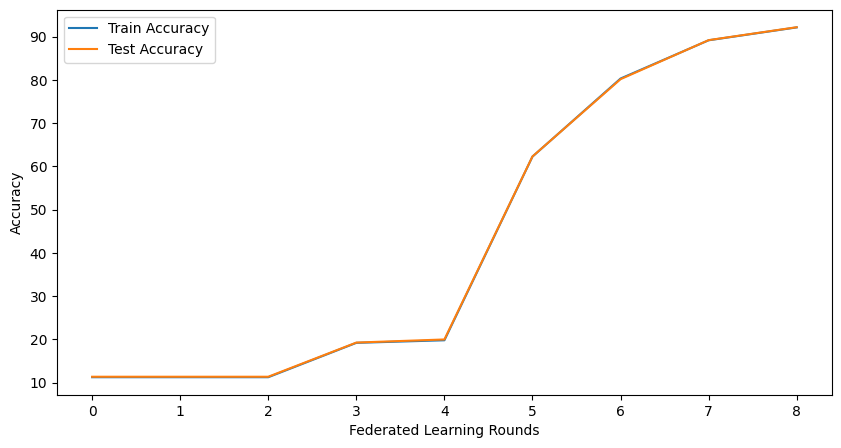

In [ ]:
# Federated Learning Training Loop

# Initialize global model and client models
global_model = CNN()
client_models = [CNN() for _ in range(4)]
criterion = nn.CrossEntropyLoss()
optimizers = [optim.SGD(client_model.parameters(), lr=0.01) for client_model in client_models]

# DataLoaders for clients
client_loaders = [DataLoader(dataset, batch_size=32, shuffle=True) for dataset in client_datasets]

train_accuracies = []
test_accuracies = []

for round in range(100):
    print(f'Round {round+1}')

    # Train each client model on its local dataset
    for i in range(4):
        train(client_models[i], client_loaders[i], criterion, optimizers[i], epochs=1)

    # Perform FedAvg
    fed_avg(global_model, client_models)

    # Update client models with the new global model weights
    for client_model in client_models:
        client_model.load_state_dict(global_model.state_dict())

    # Evaluate the global model
    train_acc = evaluate(global_model, DataLoader(mnist_train, batch_size=1000, shuffle=False))
    test_acc = evaluate(global_model, test_loader)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print(f'Train Accuracy: {train_acc:.2f}%, Test Accuracy: {test_acc:.2f}%')

    if test_acc >= 90:
        break# Plotting the results, since no need to keep going after 90%
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Federated Learning Rounds')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

the train and test set performance of the global model are almost identical
at round 4 and 6 the blue line can be seen behind the orange line.